In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

# For neural networks
import torch

# Computation of asset metrics
from portfolio_stats import PortfolioStats

# Chronological train-test splitting
from workflow.tools.model_selection import ts_train_test_split

# Neural network portfolio optimizer and objective functions
from workflow.tools.models import LSTMPortfolioOptimizer, optimization_dict
from workflow.tools.metrics import neg_sharpe_ratio, portfolio_risk

# Transaction costs
from workflow.tools.transaction_costs import net_tc

# Progress bar for loops
from tqdm.auto import tqdm

from workflow.tools.utils import set_plot_style, plot_allocations

set_plot_style()

In [2]:
# Load data
kwargs = {
    "index_col": 0,
    "parse_dates": True
}

features = pd.read_csv("workflow/data/features.csv", **kwargs)

features.head()

,BONDS,COMMODITIES,STOCKS,VOLATILIITY,BONDS_RET,COMMODITIES_RET,STOCKS_RET,VOLATILIITY_RET
Date,,,,,,,,
2006-02-07,58.516796,21.282078,44.861347,13.59,-0.000699,-0.029352,-0.009784,0.041313
2006-02-08,58.487633,21.191519,45.184086,12.83,-0.000499,-0.004264,0.007168,-0.057548
2006-02-09,58.522655,21.390755,45.098011,13.12,0.000599,0.009358,-0.001907,0.022352
2006-02-10,58.399956,21.001337,45.191250,12.87,-0.002099,-0.018373,0.002065,-0.019239
2006-02-13,58.440834,20.675314,44.986847,13.35,0.000700,-0.015646,-0.004533,0.036617


In [3]:
# Define lookback window
lookback = 50

# Calculate number of samples and features
n_samples = len(features) - lookback
n_features = len(features.columns)

# Get columns related to returns, and index names
return_cols = [col for col in features.columns if "RET" in col]
indices = features.columns[~features.columns.isin(return_cols)]

# Initialize input data with zeros
X = np.zeros((n_samples, lookback, n_features))

# Extract target values starting from the lookback index
y = features[return_cols].iloc[lookback:].values

# Populate the 'X' tensor using a rolling window of size 'lookback'
for i in range(lookback, len(features)):
    X[i-lookback] = features.iloc[i-lookback:i]

X.shape, y.shape

((4401, 50, 8), (4401, 4))

In [4]:
help(ts_train_test_split)

Help on function ts_train_test_split in module workflow.tools.model_selection:

ts_train_test_split(X: numpy.ndarray, y: numpy.ndarray, test_size: float) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Splits time-series data arrays into training and testing sets.
    
    Parameters:
    - X (np.ndarray): A 3D matrix containing input features. Shape: (samples, time_steps, features)
    - y (np.ndarray): A 2D matrix containing output targets. Shape: (samples, targets)
    - test_size (float): The proportion of the dataset to be allocated to the testing set (e.g., 0.2 for 20%).
    
    Returns:
    - X_train (np.ndarray): Training set of the input features.
    - y_train (np.ndarray): Training set of the output targets.
    - X_test (np.ndarray): Testing set of the input features.
    - y_test (np.ndarray): Testing set of the output targets.
    
    Note:
    - The function assumes that the time-series data is ordered chronologically.



In [5]:
# Train-test splitting
X_train, y_train, X_test, y_test = ts_train_test_split(X, y, test_size=0.4)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2640, 50, 8), (2640, 4), (1761, 50, 8), (1761, 4))

In [6]:
# Convert inputs and targets to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([2640, 50, 8]),
 torch.Size([2640, 4]),
 torch.Size([1761, 50, 8]),
 torch.Size([1761, 4]))

In [7]:
help(LSTMPortfolioOptimizer)

Help on class LSTMPortfolioOptimizer in module workflow.tools.models:

class LSTMPortfolioOptimizer(torch.nn.modules.module.Module)
 |  LSTMPortfolioOptimizer(input_size: int, hidden_size: int, output_size: int)
 |  
 |  A neural network model designed for portfolio optimization using LSTM layers.
 |  
 |  Attributes / Layers:
 |  - lstm (torch.nn.LSTM): LSTM layer for sequence modeling.
 |  - fc (torch.nn.Linear): Fully connected layer for transforming LSTM outputs.
 |  - softmax (torch.nn.Softmax): Softmax layer for producing probability distributions.
 |  
 |  Method resolution order:
 |      LSTMPortfolioOptimizer
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_size: int, hidden_size: int, output_size: int)
 |      Initializes the PortfolioOptimizationNN with the given dimensions.
 |      
 |      Parameters:
 |      - input_size (int): The number of input features.
 |      - hidden_size (int): The number o

In [8]:
# Load empty optimizations dictionary
optimizations = {
    "MAX_SHARPE": {
        "OBJ": neg_sharpe_ratio,
        "METRIC_PROGRESSION": [],
        "WEIGHTS": [],
        "RETURNS": None
    },
    "MINIMUM_VARIANCE": {
        "OBJ": portfolio_risk,
        "METRIC_PROGRESSION": [],
        "WEIGHTS": [],
        "RETURNS": None
    }
}

# Define input size, hidden size, and output size
input_size = X_train.shape[-1]       # 8 features
hidden_size = 64                     # 64 neurons
output_size = y_train.shape[-1]      # 4 assets

# Define number of training epochs
epochs = 150

# Loop over optimization items
for i, (opt_type, params) in tqdm(enumerate(optimizations.items()), total=len(optimizations.items())):

    # Instantiate model and optimizer
    model = LSTMPortfolioOptimizer(input_size, hidden_size, output_size)
    optimizer = torch.optim.Adam(model.parameters())

    # Construct the training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        obj = params["OBJ"](outputs, y_train_tensor)
        obj.backward()
        optimizer.step()

        params["METRIC_PROGRESSION"].append(obj.item())

    # Get the outputs (asset allocations) after training
    with torch.no_grad():
        optimizations[opt_type]["WEIGHTS"] = model(X_test_tensor)

  0%|          | 0/2 [00:00<?, ?it/s]

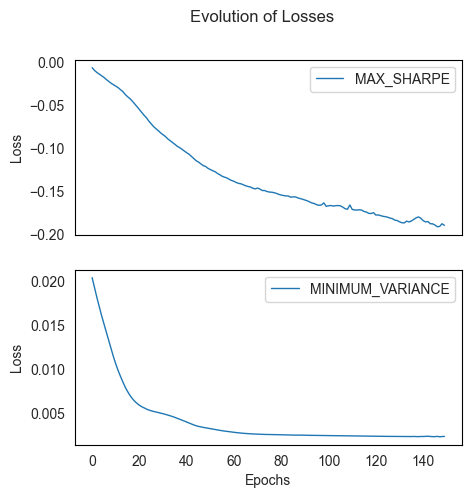

In [9]:
# Plot the evolution of losses
fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
fig.suptitle("Evolution of Losses")
axes = axes.flatten()

for ax, (opt_type, params) in zip(axes, optimizations.items()):
    ax.plot(params["METRIC_PROGRESSION"])
    ax.set_ylabel("Loss")
    ax.legend([opt_type])
    ax.grid(False)

plt.xlabel("Epochs")
plt.show()

In [10]:
# Initialize empty list for dataframe concatenation
optimized_returns = []

# Reindex returns for multiplication
reindexed_returns = features[return_cols][-len(X_test)+1:]
reindexed_returns.columns = indices

# Compute the returns for each optimized portfolio
for opt_type in optimizations.keys():

    weights = pd.DataFrame(
        optimizations[opt_type]["WEIGHTS"], 
        columns=indices, 
        index=features.index[-len(X_test):]
    ).shift().dropna()


    # Portfolio returns = sum of (weights * returns)
    returns = (weights * reindexed_returns).sum(axis=1)
    returns = net_tc(returns, weights, cost_rate=0.005)
    returns.name = opt_type

    optimizations[opt_type]["WEIGHTS"] = weights
    optimizations[opt_type]["RETURNS"] = returns
    optimized_returns.append(returns)

# Concatenate optimized returns
optimized_returns = pd.concat(optimized_returns, axis=1)
optimized_returns.loc[optimized_returns.index.min()] = 0

optimized_returns.head()

,MAX_SHARPE,MINIMUM_VARIANCE
Date,,
2016-10-14,0.000000,0.000000
2016-10-17,-0.001167,0.000856
2016-10-18,0.001385,0.001498
2016-10-19,-0.000350,0.000287
2016-10-20,-0.003906,-0.001638


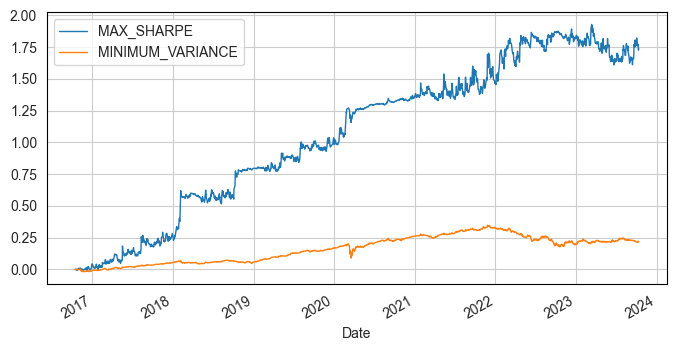

In [11]:
optimized_returns.cumsum().plot(figsize=(8, 4))
plt.show()

In [12]:
optimized_stats = PortfolioStats(optimized_returns, log=True)
optimized_stats.info

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
MAX_SHARPE,0.728802,1.742106,0.249438,0.342257,-0.318913
MINIMUM_VARIANCE,0.561505,0.215668,0.03088,0.054995,-0.171532


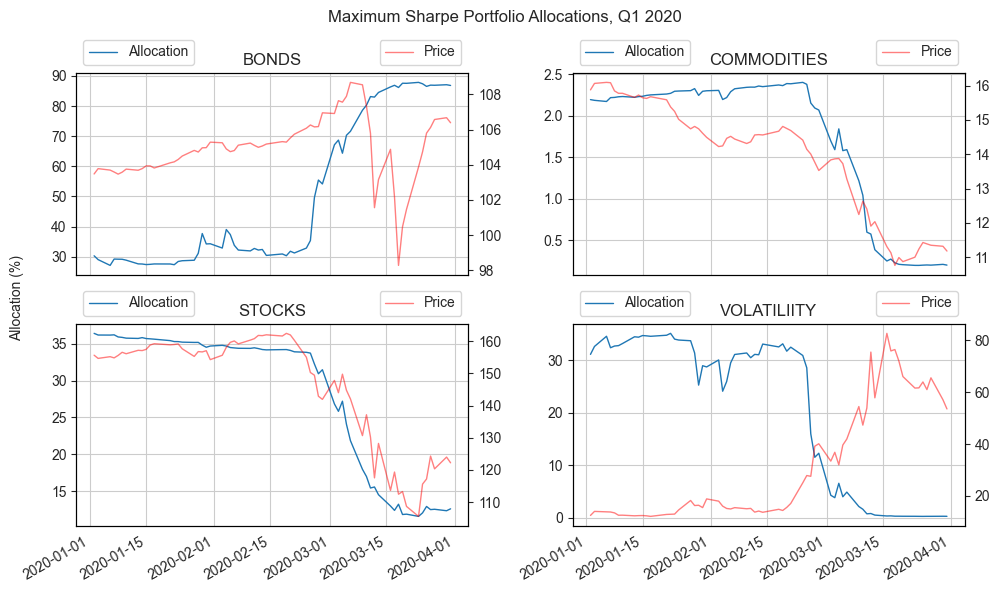

In [13]:
covid_q1 = {"start": "2020-01", "end": "2020-03"}

title = "Maximum Sharpe Portfolio Allocations, Q1 2020"
plot_allocations(optimizations["MAX_SHARPE"], features, indices, covid_q1, title)

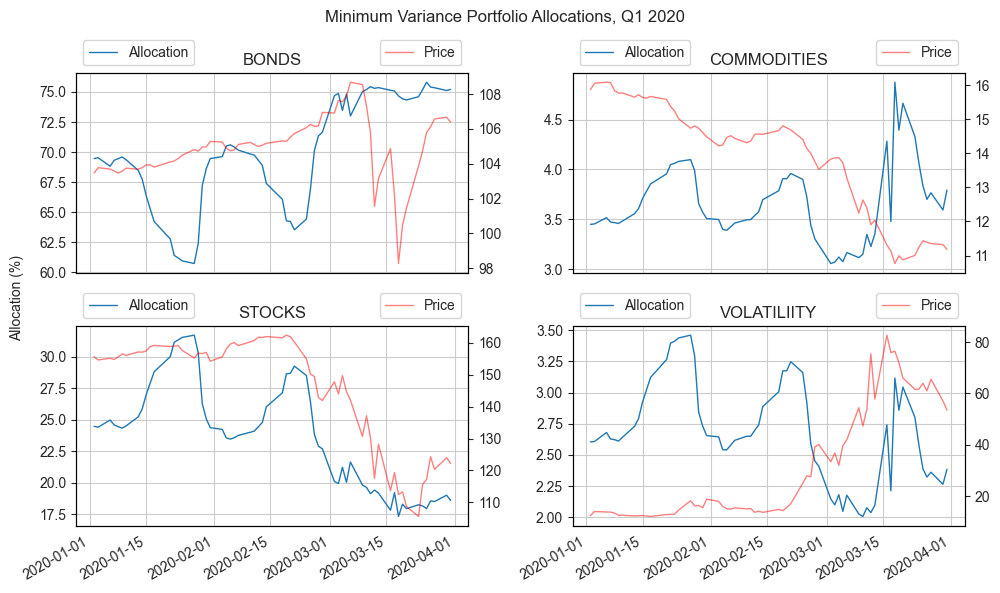

In [14]:
title = "Minimum Variance Portfolio Allocations, Q1 2020"
plot_allocations(optimizations["MINIMUM_VARIANCE"], features, indices, covid_q1, title)